# Redes de Convolução

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.datasets import load_sample_image

In [3]:
# loading fashion mnist
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [4]:
# data normalization
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000].copy(), y_train_full[5000:].copy()

In [5]:
def show_side_by_side(figs, limit = 10, figsize=(20, 4), cmap = 'gray', grid = False):
    minval = min(limit, figs.shape[0])
    plt.figure(figsize = figsize)
    for i in range(minval):
        subplot = plt.subplot(1, limit, i + 1)
        extent = (0, figs[i].shape[1], figs[i].shape[0], 0)
        subplot.imshow(figs[i], cmap = cmap, extent = extent)
        
        if grid:
            subplot.grid(color='gray', linestyle='-', linewidth=1)
        else:
            subplot.get_xaxis().set_visible(False)
            subplot.get_yaxis().set_visible(False)

    plt.show()

### Filtros de convolução

In [6]:
# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

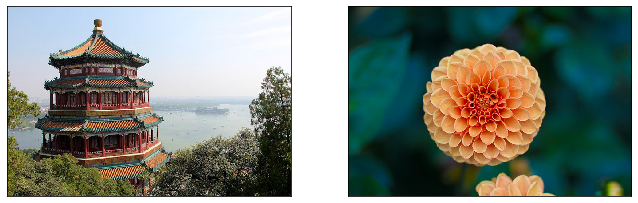

In [7]:
show_side_by_side(images, figsize = (60, 30))

In [59]:
# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32) 

In [60]:
filters.shape

(7, 7, 3, 2)

In [61]:
filters[:, 3, :, 0] = 1 # vertical line
filters[3, :, :, 1] = 1 # horizontal line

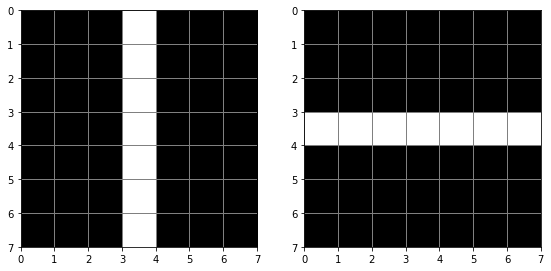

In [62]:
# filtros no canal 0
show_side_by_side(np.array([filters[:, :, 0, i] for i in range(2)]), figsize = (50, 20), grid = True)

In [12]:
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

In [13]:
outputs.shape

TensorShape([2, 427, 640, 2])

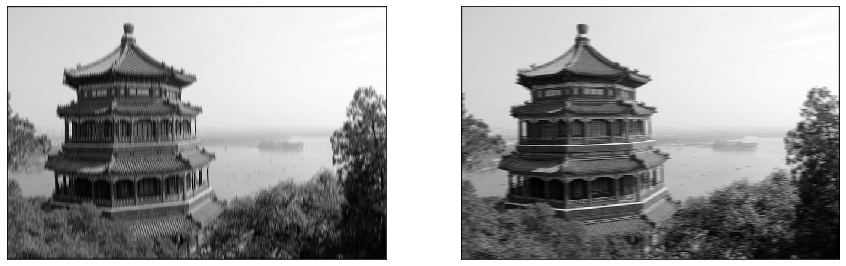

In [14]:
show_side_by_side(np.array([outputs[0, :, :, i].numpy() for i in range(2)]), figsize = (80, 20))

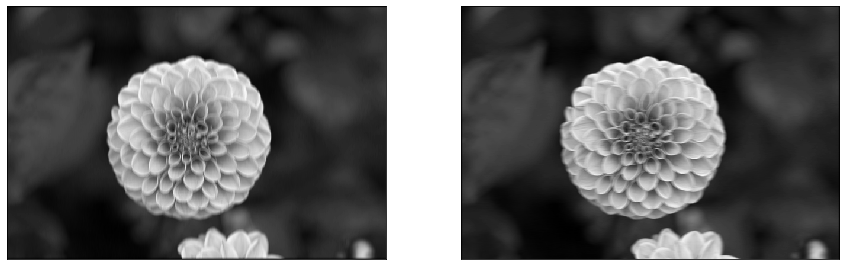

In [15]:
show_side_by_side(np.array([outputs[1, :, :, i].numpy() for i in range(2)]), figsize = (80, 20))

#### Redução de dimensionalidade com _striding_

In [16]:
outputs_2 = tf.nn.conv2d(images, filters, strides=8, padding="SAME")
outputs.shape, outputs_2.shape

(TensorShape([2, 427, 640, 2]), TensorShape([2, 54, 80, 2]))

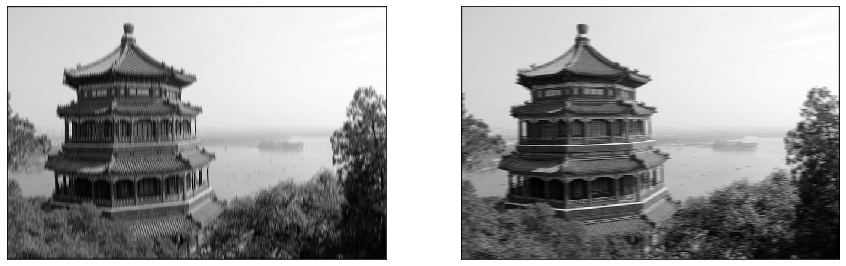

In [17]:
show_side_by_side(np.array([outputs[0, :, :, i].numpy() for i in range(2)]), figsize = (80, 20))

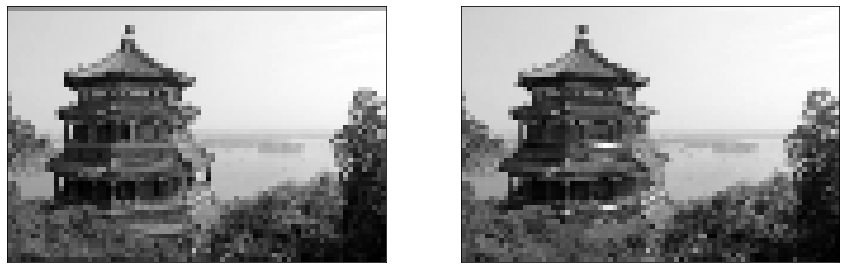

In [18]:
show_side_by_side(np.array([outputs_2[0, :, :, i].numpy() for i in range(2)]), figsize = (80, 20))

#### Redução de dimensionalidade com _pooling_

In [19]:
outputs_3 = tf.nn.max_pool(images, ksize=(1, 8, 8, 1), strides=(1, 1, 1, 1), padding="SAME")

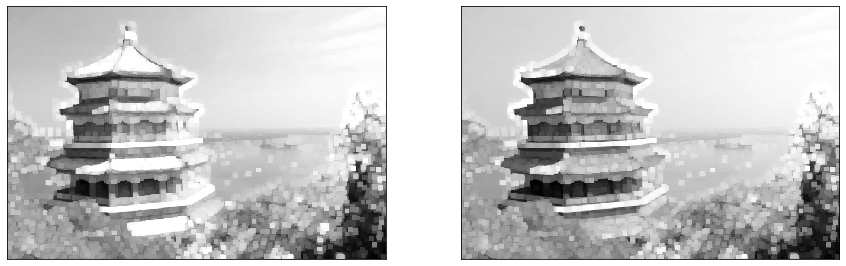

In [20]:
show_side_by_side(np.array([outputs_3[0, :, :, i].numpy() for i in range(2)]), figsize = (80, 20))

Ao contrário do striding que representa uma região por um ponto qualquer dela, o maxpooling representa pelo ponto de valor mais alto. Como resultado, temos uma imagem mais clara, com bordas se sobressaindo.

#### Convoluções 1x1 para combinação em profundidade

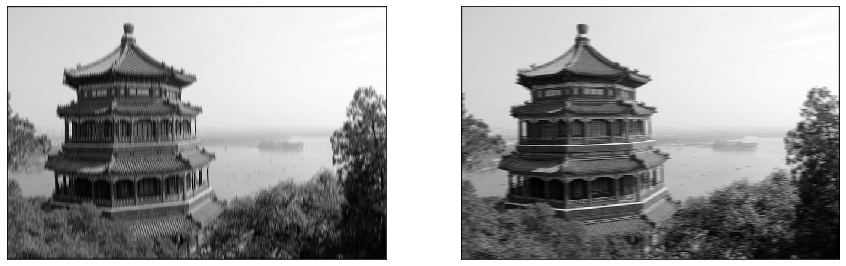

In [21]:
show_side_by_side(np.array([outputs[0, :, :, i].numpy() for i in range(2)]), figsize = (80, 20))

In [22]:
images.shape, outputs.shape

((2, 427, 640, 3), TensorShape([2, 427, 640, 2]))

In [23]:
# x, y, canais ou nro de filtros de entrada, nro de filtros de saida
# qd uso kernel 1x1, espero que nro de filtros de saida < nro de filtros de entrada
#k1x1 = np.ones(shape=(1, 1, 2, 1), dtype=np.float32) 
k1x1 = np.random.rand(1, 1, 2, 1).astype(np.float32)

In [24]:
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")
outputs_1x1 = tf.nn.conv2d(outputs, k1x1, strides=1, padding="SAME")

In [25]:
outputs_1x1.shape

TensorShape([2, 427, 640, 1])

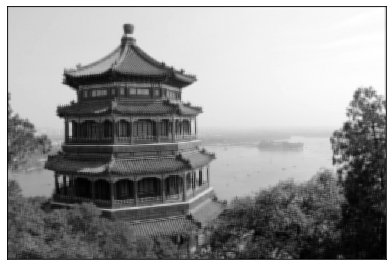

In [26]:
show_side_by_side(np.array([outputs_1x1[0, :, :, i].numpy() for i in range(1)]), figsize = (80, 20))

## Uma rede de convolução simples

In [27]:
from functools import partial
DefaultConv2D = partial(keras.layers.Conv2D,
                            kernel_size=3, activation='relu', padding="SAME")

In [28]:
# reshape para introduzir dimensao do canal
X_train = X_train.reshape((-1, 28, 28, 1))
X_valid = X_valid.reshape((-1, 28, 28, 1))

In [29]:
X_image = keras.layers.Input(shape = (28, 28, 1))

# Convolucoes
x = DefaultConv2D(filters=16, kernel_size=7)(X_image)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
x = DefaultConv2D(filters=32)(x)
x = DefaultConv2D(filters=32)(x)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
x = DefaultConv2D(filters=64)(x)
x = DefaultConv2D(filters=64)(x)
x = keras.layers.MaxPooling2D(pool_size=2)(x)

# Rede densa
x = keras.layers.Flatten()(x)
#x = keras.layers.Dense(units=32, activation='relu')(x)
#x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(units=32, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
yhat = keras.layers.Dense(units=10, activation='softmax')(x)

model = keras.models.Model(inputs = X_image, outputs = yhat)

In [30]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
h = model.fit(X_train, y_train, epochs = 3, validation_data = (X_valid, y_valid))

W1007 12:44:17.270573 4709713344 training_utils.py:1211] When passing input data as arrays, do not specify `steps_per_epoch`/`steps` argument. Please use `batch_size` instead.


Epoch 1/3


W1007 12:44:17.659976 4709713344 deprecation.py:323] From /Users/marcocristo/.local/lib/python3.6/site-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:468: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


55000/55000 [==============================] - 56s 1ms/sample - loss: 0.8573 - accuracy: 0.6728 - val_loss: 0.4179 - val_accuracy: 0.8426
Epoch 2/3
55000/55000 [==============================] - 54s 974us/sample - loss: 0.5687 - accuracy: 0.7871 - val_loss: 0.3380 - val_accuracy: 0.8744
Epoch 3/3
55000/55000 [==============================] - 55s 1ms/sample - loss: 0.4717 - accuracy: 0.8255 - val_loss: 0.3210 - val_accuracy: 0.8816


## Uma rede de convolução residual -- A ResNet34

Tendência: redes cada vez mais profundas com cada vez menos parâmetros!

```X = Imagem
x = Conv(K=7x7, N=64, s2, relu, same sem bias)(X)
x = BN()(x)
x = MaxPool(K=3x3, s2, same sem bias)(x)
x = R(K=3x3, N=64, s1)(x)
x = R(K=3x3, N=64, s1)(x)
x = R(K=3x3, N=64, s1)(x)
x = R(K=3x3, N=128, s2)(x)
x = R(K=3x3, N=128, s1)(x)
x = R(K=3x3, N=128, s1)(x)
x = R(K=3x3, N=128, s1)(x)
x = R(K=3x3, N=256, s2)(x)
x = R(K=3x3, N=256, s1)(x)
x = R(K=3x3, N=256, s1)(x)
x = R(K=3x3, N=256, s1)(x)
x = R(K=3x3, N=256, s1)(x)
x = R(K=3x3, N=256, s1)(x)
x = R(K=3x3, N=512, s2)(x)
x = R(K=3x3, N=512, s1)(x)
x = R(K=3x3, N=512, s1)(x)
x = AvgPool()(x)
x = FC(1000, softmax)(x)

Def R(entrada X, kernel K, número de filtros N, stride S):
    x = Conv(KxK, N, sS, relu, same sem bias)(X)
    x = BN()(x)
    x = Conv(KxK, N, s1, relu, same sem bias)(x)
    x = BN()(x)
    if S>1:
        x = Conv(1x1, N, sS, relu, same sem bias)(x)
        x = BN()(x)
    Return a(x + X), a é a função de ativação
```

In [64]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                            padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation) 
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = [] 
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]
                
    def call(self, inputs): 
        skip_Z = inputs
        Z = inputs
        for layer in self.main_layers: 
            Z = layer(Z)
        # shape compatibility layers
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [32]:
X_input = keras.layers.Input(shape = (224, 224, 3))

x = DefaultConv2D(64, kernel_size=7, strides=2)(X_input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME")(x)

prev_filters = 64 
for filters in [64]*3+[128]*4+[256]*6+[512]*3:
    strides = 1 if filters == prev_filters else 2 
    x = ResidualUnit(filters, strides=strides)(x) 
    prev_filters = filters

x = keras.layers.GlobalAvgPool2D()(x)
x = keras.layers.Flatten()(x)
yhat = keras.layers.Dense(10, activation="softmax")(x)

model = keras.models.Model(inputs = X_input, outputs = yhat)

In [33]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 56, 56, 64)        7424

## Usando modelos pré-treinados

In [34]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

In [35]:
images_resized = tf.image.resize(images, [224, 224])

In [36]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)

In [37]:
Y_proba = model.predict(inputs)

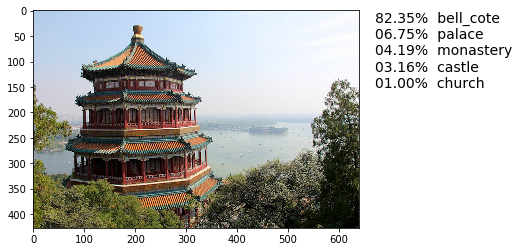

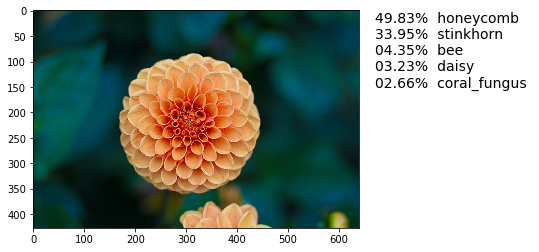

In [39]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=5) 
for i in range(len(images)):
    plt.figure()
    plt.imshow(images[i])    
    sclasses = '\n'.join(["{:05.2f}%  {:12s}".format(y_proba * 100, name) 
                          for class_id, name, y_proba in top_K[i]])
    plt.text(670, 150, sclasses, fontsize=14)

### Um ataque adversarial

In [40]:
image_raw = tf.io.read_file('/Users/marcocristo/Documents/aulas/ammd2/2019/imagens/arara.jpg')
image = tf.image.decode_image(image_raw)
image.shape

TensorShape([638, 850, 3])

In [41]:
image_resized = tf.image.resize(image, [224, 224])

In [42]:
image_resized.shape

TensorShape([224, 224, 3])

In [43]:
image_reshaped = tf.expand_dims(image_resized, 0)

In [44]:
image_prepro = keras.applications.resnet50.preprocess_input(image_reshaped)

W1007 12:49:07.639848 4709713344 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


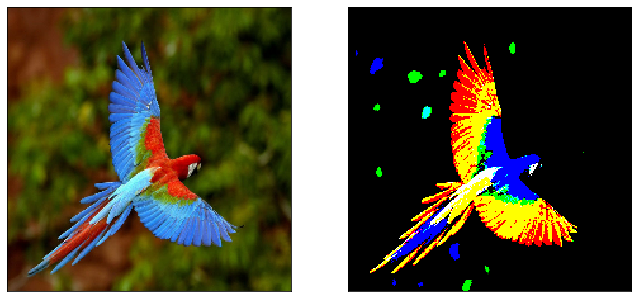

In [45]:
show_side_by_side(np.array([image_reshaped[0].numpy()/255, image_prepro[0].numpy()]),
                 figsize = (60, 30))

In [46]:
Y_proba = model.predict(image_prepro)
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=5) 

In [47]:
top_K

[[('n01818515', 'macaw', 0.9873947),
  ('n01820546', 'lorikeet', 0.011042246),
  ('n01828970', 'bee_eater', 0.0014859921),
  ('n01950731', 'sea_slug', 1.5931926e-05),
  ('n01443537', 'goldfish', 1.2373894e-05)]]

In [48]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(pretrained_model, X, input_label):
    with tf.GradientTape() as tape:
        tape.watch(X)
        prediction = pretrained_model(X)
        loss = loss_object(input_label, prediction)

    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, X)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    return signed_grad, gradient

In [49]:
perturbations, grads = create_adversarial_pattern(model, image_prepro, Y_proba)

W1007 12:49:18.826838 4709713344 deprecation.py:323] From /Users/marcocristo/.local/lib/python3.6/site-packages/tensorflow_core/python/ops/math_grad.py:1393: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [50]:
print(grads[0, :, 0, 0][:10])
print(perturbations[0, :, 0, 0][:10])

tf.Tensor(
[-9.9757158e-10 -2.8448624e-10  6.4057215e-10 -1.5392361e-11
  1.4096633e-09  1.1810417e-10 -7.8257706e-10  9.9689579e-10
  1.0196735e-09  9.3300818e-11], shape=(10,), dtype=float32)
tf.Tensor([-1. -1.  1. -1.  1.  1. -1.  1.  1.  1.], shape=(10,), dtype=float32)


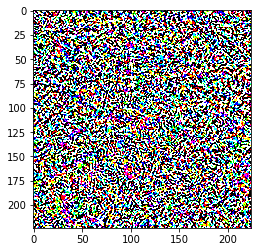

In [51]:
plt.imshow(tf.clip_by_value(perturbations[0], 0, 1))

In [52]:
epsilon = 2
adv_image = (epsilon * perturbations + image_reshaped)

In [53]:
image_reshaped.shape, perturbations.shape, adv_image.shape

(TensorShape([1, 224, 224, 3]),
 TensorShape([1, 224, 224, 3]),
 TensorShape([1, 224, 224, 3]))

W1007 12:49:34.142827 4709713344 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


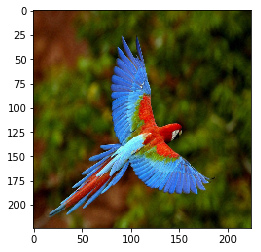

In [54]:
plt.imshow(adv_image[0]/255)

In [55]:
inputs_adv = keras.applications.resnet50.preprocess_input(adv_image)
Y_proba = model.predict(inputs_adv)
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=5) 
top_K

[[('n01950731', 'sea_slug', 0.44838303),
  ('n01820546', 'lorikeet', 0.08231645),
  ('n02317335', 'starfish', 0.078202374),
  ('n12620546', 'hip', 0.03762333),
  ('n01818515', 'macaw', 0.03434711)]]

In [56]:
def show_adv(perturbations, image_reshaped, epsilon = 0):
    adv_image = (epsilon * perturbations + image_reshaped)

    inputs_adv = keras.applications.resnet50.preprocess_input(adv_image)
    Y_proba = model.predict(inputs_adv)
    top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=5) 

    plt.figure()
    plt.imshow(tf.clip_by_value(adv_image[0]/255, 0, 1))
    sclasses = 'epsilon: {:.2f}\n'.format(epsilon)
    sclasses += '\n'.join(["{:05.2f}%  {:12s}".format(y_proba * 100, name) 
                          for class_id, name, y_proba in top_K[0]])
    plt.text(250, 150, sclasses, fontsize=14)

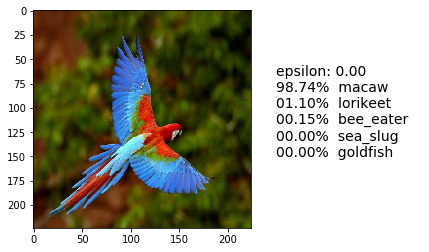

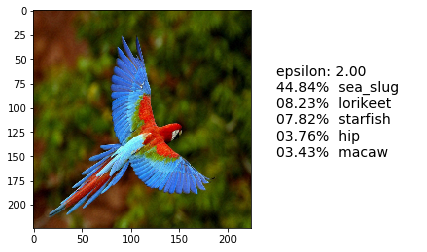

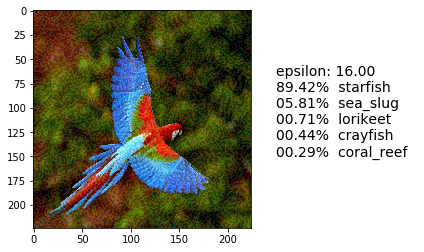

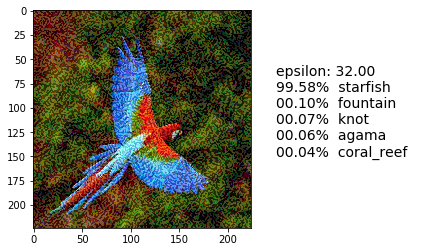

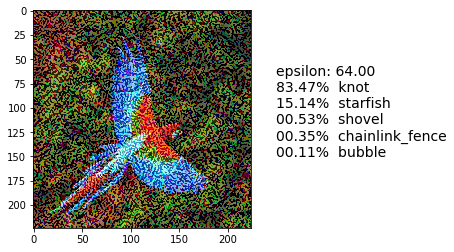

In [57]:
for e in [0.0, 2.0, 16.0, 32.0, 64.0]:
    show_adv(perturbations, image_reshaped, epsilon = e)

### Acelerando uma CNN em uma máquinas com várias GPUs